![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [161]:
import warnings
warnings.filterwarnings('ignore')

In [162]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [163]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [164]:
# Celda 1.1
bikes.groupby('season').total.mean()
bikes['season'].describe()

count    10886.000000
mean         2.506614
std          1.116174
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          4.000000
Name: season, dtype: float64

In [165]:
value_counts=bikes['season'].value_counts()
print(value_counts)

4    2734
3    2733
2    2733
1    2686
Name: season, dtype: int64


La variable season es una variable categorica donde cada una de las temporadas del año toma un valor de 1-4. Podemos ver que la variables que mas se repite es la 4 que es el otoño y la que menos se repite es el 1 que es el verano pero hay una distribudcion muy similar.

In [166]:
# Celda 1.2
bikes.groupby('hour').total.mean()
bikes['hour'].describe()

count    10886.000000
mean        11.541613
std          6.915838
min          0.000000
25%          6.000000
50%         12.000000
75%         18.000000
max         23.000000
Name: hour, dtype: float64

La variable de horas tiene un minimo de 0:00 y un maximo de 23 lo cual quiere decir que las personas alquilan biciecletas en todas las horas del dia, pero el promedio es alrededor de las 11-12 del día que parece ser la hora más popular.

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<Axes: xlabel='hour'>

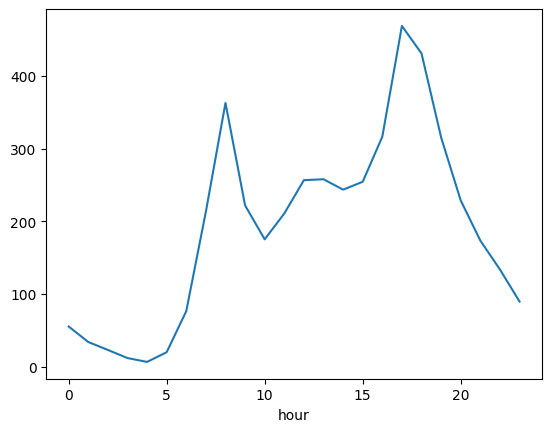

In [167]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

1    2686
Name: season, dtype: int64


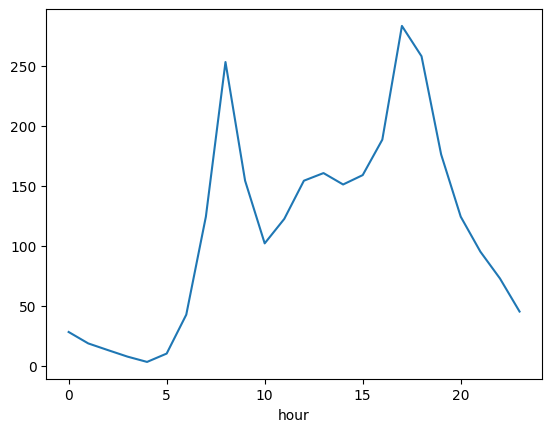

In [168]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 
bikes1=bikes.loc[bikes['season'] == 1]
bikes1.groupby('hour').total.mean().plot()
value_counts=bikes1['season'].value_counts()
print(value_counts)

3    2733
4       0
2       0
1       0
Name: season, dtype: int64


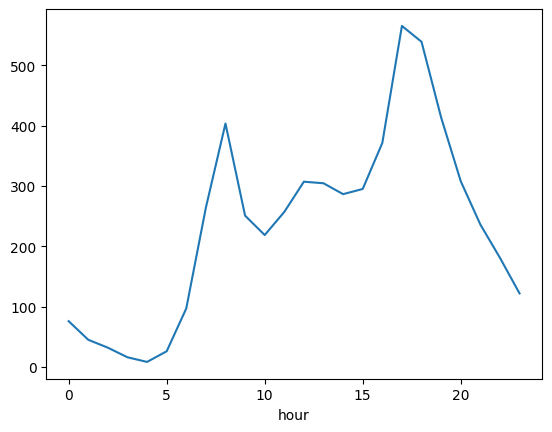

In [173]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
bikes1=bikes.loc[bikes['season'] == 3]
bikes1.groupby('hour').total.mean().plot()
value_counts=bikes1['season'].value_counts()
print(value_counts)

Al mirar como se distribuye el numero de alquileres en las horas del día, podemos ver que hay unos picos al rededor de las 7 y otro al rededor de las 16 en donde se alquilan mas bicicletas. Aunque hay algunos cambios cuando se ven las estaciones especificas, no parece ser tan grane lo cual lleva a creer que el número de biciceltas alquilado a ciertas horas no se ve altamente dterminado por la estacion del año.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [170]:
# Celda 3
bikes['season']=bikes['season'].astype('category')

feature_cols = bikes[['hour', 'season']]
y=bikes['total']
X = feature_cols

reg = LinearRegression().fit(X, y)

In [171]:
reg.coef_

array([10.52129824, 26.95130851])

In [172]:
reg.intercept_

2.5848513346808204

Haciendo una regresion lineal para tratar de estimar el total de bicicletas alquiladas por las variables season y hour parece ser que en cambios de la hora, el numero de bicicletas aumenta en 10 mientras que con cambios en la temporada del año podemos ver aumentos en el alquier de bibicletas en 26. Algunas limitaciones pueden ser la asuncion de normalidad, problemas de linealidad y la variable categorica como referente.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [ ]:
def stdev(y):
    n = len(y)
    if n <= 1:
        return 0.0
    mean = sum(y) / n
    variance = sum([(yi - mean)**2 for yi in y]) / (n - 1)
    return variance**0.5

In [ ]:
def split_data(x, y, split_variable, split_value):
    x_left, y_left, x_right, y_right = [], [], [], []
    for i in range(len(x)):
        if x[i][split_variable] == split_value:
            x_left.append(x[i])
            y_left.append(y[i])
        else:
            x_right.append(x[i])
            y_right.append(y[i])
    return x_left, y_left, x_right, y_right

In [ ]:
def find_best_split(x, y):
    best_variance_reduction = 0
    best_split_variable = None
    best_split_value = None
    for i in range(len(x[0])):
        values = list(set([d[i] for d in x]))
        for value in values:
            x_left, y_left, x_right, y_right = split_data(x, y, i, value)
            if len(y_left) > 0 and len(y_right) > 0:
                y_total = sum(y)
                y_left_total = sum(y_left)
                y_right_total = sum(y_right)
                fraction_left = len(y_left) / len(y)
                fraction_right = len(y_right) / len(y)
                variance_reduction = stdev(y) - fraction_left*stdev(y_left) - fraction_right*stdev(y_right)
                if variance_reduction > best_variance_reduction:
                    best_variance_reduction = variance_reduction
                    best_split_variable = i
                    best_split_value = value
    return {"variable": best_split_variable, "threshold": best_split_value, "variance_reduction": best_variance_reduction}


In [ ]:
def build_tree(x, y, min_samples_leaf=5, max_depth=3):
    # Verificar si se ha alcanzado la profundidad máxima o si todos los datos son iguales
    if max_depth == 0 or len(set(y)) == 1 or len(x) <= min_samples_leaf:
        return {"leaf": True, "value": sum(y)/len(y)}
    # Encontrar la mejor división para cada variable y elegir la mejor división general
    best_split = {"variable": None, "threshold": None, "left": None, "right": None}
    for i in range(len(x[0])):
        split = find_best_split(x, y)
        if best_split["variable"] is None or split["threshold"] is not None and split["variance_reduction"] > best_split["variance_reduction"]:
            best_split = split
    # Verificar si no se puede encontrar una buena división
    if best_split["threshold"] is None:
        return {"leaf": True, "value": sum(y)/len(y)}

In [ ]:
def build_tree(x, y, z, min_samples_leaf=2, max_depth=3):
    # Verificar si se ha alcanzado la profundidad máxima o si todos los datos son iguales
    if max_depth == 0 or len(set(y)) == 1 or len(x) <= min_samples_leaf:
        return {"leaf": True, "value": sum(z)/len(z)}
    # Encontrar la mejor división para cada variable y elegir la mejor división general
    best_split = {"variable": None, "threshold": None, "left": None, "right": None}
    for i in range(len(x[0])):
        split = find_best_split([d[i] for d in x], y, z, i)
        if best_split["variable"] is None or split["threshold"] is not None and split["variance_reduction"] > best_split["variance_reduction"]:
            best_split = split
    # Verificar si no se puede encontrar una buena división
    if best_split["threshold"] is None:
        return {"leaf": True, "value": sum(z)/len(z)}
    # Construir los sub-árboles recursivamente
    left_tree = build_tree(best_split["left"][0], best_split["left"][1], best_split["left"][2], min_samples_leaf, max_depth-1)
    right_tree = build_tree(best_split["right"][0], best_split["right"][1], best_split["right"][2], min_samples_leaf, max_depth-1)
    # Unir todo en un solo diccionario de árbol
    return {"leaf": False, "variable": best_split["variable"], "threshold": best_split["threshold"], "left": left_tree, "right": right_tree}

# Construir el árbol de decisión con al menos 6 nodos terminales
tree = build_tree(list(zip(x, y)), z, min_samples_leaf=1, max_depth=4)

In [160]:
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)
bikes.rename(columns={'count':'total'}, inplace=True)
bikes['hour'] = bikes.index.hour
bikes['invierno'] = np.where(bikes['season']== 1, 1, 0)
bikes['primavera'] = np.where(bikes['season']== 2, 1, 0)
bikes['verano'] = np.where(bikes['season']== 3, 1, 0)
bikes['otono'] = np.where(bikes['season']== 4, 1, 0)

URLError: <urlopen error [Errno 11001] getaddrinfo failed>

In [ ]:
feature_cols = bikes[['hour', 'invierno', 'primavera', 'verano', 'otono']]
y=bikes['total']
X = feature_cols

In [ ]:
# Celda 4
j = 0
print(X.columns[j])
k=5


splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / 10).tolist())
splits = np.unique(splits)
splits


In [57]:
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)
    
# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [58]:
gini_impurity(X.iloc[:, j], y, splits[k])

10610.413579790038

In [65]:
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0,0,0,0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [66]:
j, split, gain = best_split(X, y, 5)
j, split, gain

(0, 8.0, 18268.811823533004)

In [67]:
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [68]:
tree = tree_grow(X, y, level=0, min_gain=0.001, max_depth=3, num_pct=10)
tree

ValueError: too many values to unpack (expected 3)

In [ ]:


# Ganancia de la variable 'Hits' en el punto de corte selecionado


# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol



# Obtención de la variable 'j', su punto de corte 'split' y su ganancia 'gain'
j, split, gain = best_split(X, y, 5)
j, split, gain

# División de las observaciones usando la mejor variable 'j' y su punto de corte 'split'
filter_l = X.iloc[:, j] < split

y_l = y.loc[filter_l]
y_r = y.loc[~filter_l]

y.shape[0], y_l.shape[0], y_r.shape[0]

y.mean(), y_l.mean(), y_r.mean()

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

In [174]:
# Celda 5
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)
bikes.rename(columns={'count':'total'}, inplace=True)
bikes['hour'] = bikes.index.hour
bikes['season']=bikes['season'].astype('category')

feature_cols = bikes[['hour', 'season']]
y=bikes['total']
X = feature_cols

max_depth_range = range(3, 21)
min_samples_leaf=range(500,1000)
accuracy_scores = []

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [175]:
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf = DecisionTreeRegressor(criterion='squared_error',max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10).mean())

Text(0, 0.5, 'Accuracy')

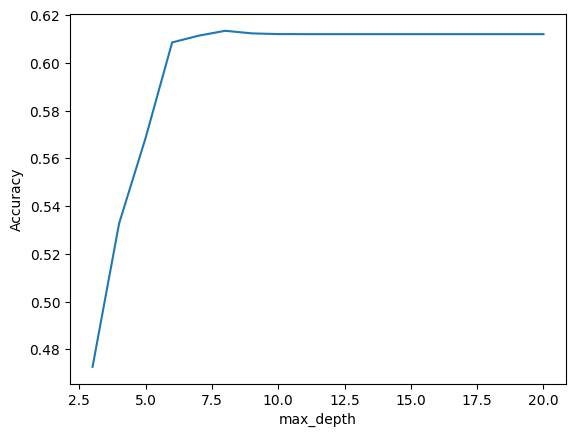

In [176]:
import matplotlib.pyplot as plt
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [177]:
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

(0.6134052369062071, 8)

In [178]:
clf = DecisionTreeRegressor(criterion='squared_error',max_depth=6, random_state=1)
clf.fit(X, y)
cross_val_score(clf, X, y, cv=10).mean()

predictions = clf.predict(X_test)


mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

Mean Squared Error: 13853.12
R-squared: 0.57


Al hacer un arbol de regresión con estos datos, podemos ver que los resultados que se obtienen son bastante buenos pues el R cuadrado alcanza un valor de 0.57. En este caso hay algunas mejorías comparado con la regresión lineal pues se pueden analizar e interpretar los datos más facilmente y se tiene menor sensibilidad a los outliers.  

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [103]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [104]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [105]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [107]:
feature_cols = df.drop(['url', 'Popular'], axis=1)
y=df['Popular']
X = feature_cols

In [ ]:
df['Popular'].describe()

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [120]:
# Celda 6
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
log = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = log.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Exactitud: {:.2f}%".format(accuracy * 100))

max_depth_range = range(3, 21)
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf =  DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X_test, y_test, cv=10).mean())


In [121]:
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

(0.1368768537256268, 6)

In [122]:
clf = DecisionTreeClassifier(criterion='squared_error',max_depth=6, random_state=1)
clf.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=6, random_state=1)

In [127]:
predictions = clf.predict(X_test)
prdict = (predictions > 0.5).astype(int)

In [129]:
accuracy = accuracy_score(y_test, prdict)
f1 = f1_score(y_test, prdict, average='weighted')
print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.63
F1 Score: 0.63


### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth tome un valor de su elección\
-100 árboles de decisión donde min_samples_leaf tome un valor de su elección\
-100 regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

In [114]:
# Celda 7
n_samples = X_train.shape[0]
n_B = 300

samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
samples

[array([2877,  852, 2854, ..., 4378, 3876,  783]),
 array([ 914,  993, 1426, ..., 3495, 3481, 1411]),
 array([2453,  310, 4099, ..., 2239, 3418,  393]),
 array([1295, 4012,  473, ...,  965, 4075,  813]),
 array([3594, 4409,  672, ..., 2956, 3677,  320]),
 array([1034, 2564, 1217, ..., 3152, 2664, 1642]),
 array([3557, 3356, 1249, ...,  345,  634, 1095]),
 array([1512, 2028, 1997, ..., 1537, 2212,  344]),
 array([3345,   76, 2370, ..., 1483, 3552, 1687]),
 array([3882, 2632, 2639, ..., 2601, 1560, 2164]),
 array([ 917, 4404, 3359, ..., 3078, 4374,  557]),
 array([3617, 1001, 1490, ..., 3248, 2178, 3189]),
 array([1664, 1353, 2271, ..., 4229, 1044, 2916]),
 array([ 227, 2614, 2627, ..., 3324, 1864, 3042]),
 array([ 401, 2971, 2491, ..., 3227, 1919,  701]),
 array([2475, 4395, 2554, ..., 3032, 2816, 1663]),
 array([1325, 3476, 4139, ..., 1873, 4006, 3205]),
 array([1279, 1409, 1058, ..., 2180, 1246, 1274]),
 array([1592, 1848, 3079, ...,  933, 4421,  665]),
 array([ 382, 3058, 3136, ..., 

In [141]:
treereg = DecisionTreeClassifier(max_depth=20, random_state=123)

# DataFrame para guardar las predicciones de cada árbol
y_pred = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])
accuracy =pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])
f1=pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])


# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
    treereg.fit(X_train, y_train)
    y_pred.iloc[:,i] = treereg.predict(X_test)
    prdict = (predictions > 0.5).astype(int)
    accuracy.iloc[:,i] =accuracy_score(y_test, prdict)
    f1.iloc[:,i] = f1_score(y_test, prdict, average='weighted')
    
    
y_pred

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
1483,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2185,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2520,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3721,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3727,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3077,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
5166,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2227,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
5684,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [142]:
treereg = DecisionTreeClassifier(min_samples_leaf=50, random_state=123)

# DataFrame para guardar las predicciones de cada árbol
y_pred1 = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])
accuracy1 =pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])
f11=pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

modelos=range(0,100)
# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, modelos in enumerate(modelos):
    treereg.fit(X_train, y_train)
    y_pred1.iloc[:,i] = treereg.predict(X_test)
    prdict = (predictions > 0.5).astype(int)
    accuracy1.iloc[:,i] =accuracy_score(y_test, prdict)
    f11.iloc[:,i] = f1_score(y_test, prdict, average='weighted')
    
y_pred1

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
1483,1,1,1,1,1,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2185,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2520,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3721,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3727,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3077,1,1,1,1,1,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5166,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2227,1,1,1,1,1,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5684,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [143]:
treereg = LogisticRegression(random_state=0).fit(X_train, y_train)

# DataFrame para guardar las predicciones de cada árbol
y_pred2 = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])
accuracy2 =pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])
f12=pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

modelos=range(0,100)
# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, sample in enumerate(modelos):
    treereg.fit(X_train, y_train)
    y_pred2.iloc[:,i] = treereg.predict(X_test)
    prdict = (predictions > 0.5).astype(int)
    accuracy2.iloc[:,i] =accuracy_score(y_test, prdict)
    f12.iloc[:,i] = f1_score(y_test, prdict, average='weighted')
    
    
n_estimators = 100
np.random.seed(123)y_pred2

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
1483,1,1,1,1,1,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2185,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2520,1,1,1,1,1,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3721,1,1,1,1,1,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3727,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3077,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5166,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2227,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5684,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [148]:
n_estimators = 100
np.random.seed(123)
seeds = np.random.randint(1, 10000, size=n_estimators)

trees = {}
for i in range(n_estimators):
    trees[i] = DecisionTreeClassifier(max_features="sqrt", max_depth=20, random_state=seeds[i])
    trees[i] = DecisionTreeClassifier(max_features="sqrt", min_samples_leaf=50, random_state=seeds[i])
    trees[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])

In [149]:
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = trees[i].predict(X_test)

y_pred_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
1483,0,0,1,1,1,1,1,1,1,1,...,1,0,1,1,1,1,1,1,1,0
2185,1,1,1,1,0,0,1,1,0,1,...,1,1,1,1,1,1,1,1,1,1
2520,1,1,1,0,0,1,1,1,1,1,...,1,1,1,0,0,1,1,0,1,1
3721,1,1,1,1,1,1,0,1,0,1,...,1,1,1,1,1,1,1,1,1,1
3727,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [154]:
# Desempeño al hacer votación mayoritaria
from sklearn import metrics
y_pred = (predictions > 0.5).astype(int)
metrics.f1_score(y_pred, y_test)

0.6227303295225286

In [155]:
metrics.accuracy_score(y_pred, y_test)

0.626

### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [156]:
# Celda 8
samples_oob = []
# Obtención de las observaciones fuera de la bolsa "out-of-bag" para cada muestra
for sample in samples:
    samples_oob.append(sorted(set(range(n_samples)) - set(sample)))
    
errors = np.zeros(n_estimators)

for i in range(n_estimators):
    y_pred_ = trees[i].predict(X_train.iloc[samples_oob[i]])
    errors[i] = 1 - metrics.accuracy_score(y_train.iloc[samples_oob[i]], y_pred_)
    
    

In [157]:
alpha = (1 - errors) / (1 - errors).sum()
weighted_sum_1 = ((y_pred_df) * alpha).sum(axis=1)
weighted_sum_1.head(20)

1483    0.799415
2185    0.792372
2520    0.741810
3721    0.910329
3727    0.158986
4524    0.560764
234     0.030204
4735    0.229689
5839    0.478371
2939    0.609198
3053    0.710712
867     0.651351
276     0.870358
5798    0.080636
3512    0.861165
5789    0.111045
3198    0.722571
5908    0.919410
5718    0.319332
2687    0.118993
dtype: float64

In [159]:
y_pred = (weighted_sum_1 > 0.5).astype(int)
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

(0.6649006622516556, 0.6626666666666666)

### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

In [ ]:
# Celda 9